# Community Detection in Hypergraph Networks

## Workbench

In [1]:
import numpy as np
import scipy.sparse as ssp
import random
from collections import Counter
from scipy.sparse.linalg import eigsh
import pandas as pd
from multiprocessing import Pool, cpu_count
from functools import partial, reduce
from sklearn.manifold import TSNE
from itertools import permutations, combinations, combinations_with_replacement 
from math import factorial

In [2]:
%matplotlib inline
import pylab as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

In [3]:
from bokeh.io import output_notebook, show, save
from bokeh.plotting import figure
from bokeh.models import HoverTool, ColumnDataSource
output_notebook()

Loading BokehJS ...

In [4]:
def get_nodes(x,G):
    return tuple(sorted(G[x,:].nonzero()[1]))
    
def get_hyperedges(G):
    # G: a edge-by-node incidence matrix
    pool=Pool(cpu_count()-1)
    E=Counter(pool.map(partial(get_nodes,G=G), (G.sum(axis=1).A.flatten()>1).nonzero()[0]))
    pool.close()
    pool.join()
    return E.keys()

def get_incidence(edges):
    indices=[]
    indptr=[0]
    for e in edges:
        indptr.append(indptr[-1]+len(e))
        indices+=list(e)
    return ssp.csr_matrix((np.ones(indptr[-1]), indices, indptr))

def load_edges(filename, sep='\t'):
    data=pd.read_csv(filename,sep)
    return ssp.csr_matrix((np.ones(len(data)),zip(*data.values)),shape=data.max().values+1)

In [5]:
# Given an edge-by-node incidence matrix, this function returns the submatrix corresponding to the largest connected component. 
# If the associated adjacency matrix is weighted, edges with weights less than the threshold will be removed before finding components.
def largest_component(G,threshold=None):
    P=G.T*G
    if threshold is None:
        weights=Counter(P.data)
        t=input("Tell me where to cut. Edges with weights >= will be kept. Here is the distribution of weights:\n{}".format(weights))
    else:
        t=threshold
    for i in range(1,t):
        P[P==i]=0
        P.eliminate_zeros()
    _,comp=ssp.csgraph.connected_components(P, directed=False)
    largest_comp=Counter(comp).most_common(1)[0]
    nodes=(comp==largest_comp[0]).nonzero()[0]
    G2=G[:,nodes]
    edges=G2.sum(axis=1).nonzero()[0]
    return G2[edges,:], nodes, edges

## Stochastic Block Model

* Given an order-$m$ hypergraph with $N$ nodes and $M$ hyperedges (edges for short). 
* Let $A$ be the order-$m$ adjacency tensor.  
* The stochastic block model for hypergraphs (SBMH) is defined as follows:
 * The nodes are divided into $K$ disjoint communities, $V=V_1\cap V_2 \cap \cdots \cap V_K$.
 * The probability that nodes $i_1,\cdots,i_m$ will form an edge is 
$$P(A[i_1,\cdots,i_m]=1) = C[g(i_1),\cdots,g(i_m)]\prod_{j~\text{in}~(i_1,\cdots,i_m)}\theta_j,$$
where $g(i)$ is the community that node $i$ belongs to, and $\theta_i$ is a connectivity paramter for $i$.
 * $C$ is also an order-$m$ tensor and $C[g_1,\cdots,g_m]$ is the "density" of edges between communities $g_1,\cdots,g_m$. $C$ is much smaller than $A$.
* Let $Q$ be the tensor where $Q[i_1,\cdots,i_m]= P(A[i_1,\cdots,i_m]=1)$, $1\leq i_1,\cdots,i_m \leq N$, and $B$ be the matrix where $B[i,k]=1$ if node $i$ is in community $k$.
* Then SBMH can be written as
$$Q[i_1,\cdots,i_m] = \sum_{g_1,\cdots,g_m} C[g_1,\cdots,g_m] \theta_{i_1}B[i_1,g_1] \cdots \theta_{i_m} B[i_m,g_m].$$
* In tensor form, $Q = [C; \theta B, \cdots, \theta B]$.
* In other words, the SBMH assumes that the adjacency tensor can be approximated by a Tucker decomposition $[C; \theta B, \cdots, \theta B]$. 

In [6]:
# This function generate a hypergraph (actually, all hyperedges) from the SBM with the following C: the diagonal elements of C = pwithin and the off-diagonal elements of C = pbetween
def generate(N,M,m,comm,pwithin,pbetween):
    V=range(N)
    edges=set()
    typecount=[0,0]
    while len(edges)<M:
        v=random.sample(V,m)
        if len(np.unique(comm[v]))>1:
            p=pbetween
            t=1
        else:
            p=pwithin
            t=0
        if random.random()<=p:
            edges.add(tuple(sorted(v)))
            typecount[t]+=1
    print("between: {}, within: {}".format(typecount[1],typecount[0]) )
    return list(edges)

## Hyper-SCORE

Given a hypergraph, hyper-SCORE fits the SBM to data and infers the community membership of nodes.
1. Perform a Tucker decomposition of the adjacency tensor $A$.
    1. Higher-order SVD (HOSVD) of $A$ as the initial decomposition. 
        1. Obtain the mode-1 matrix $A^{(1)}$ of $A$ by mapping indices as the following: $$A^{(1)}[i_1, \sum_{j=2}^m i_j N^{m-j}] = A[i_1,\cdots,i_m].$$
        2. Compute the $K$ left singular vectors $(u_1,\cdots,u_K)$ of $A^{(1)}$ corresponding to the $K$ largest singular values. 
            * If $A^{(1)}$ is too wide ($N$ by $N^{m-1}$) to do SVD, compute the eigen vectors of $A^{(1)}A^{(1)^T}$, since $A^{(1)}A^{(1)^T}$ can be much smaller than $A^{(1)}$ and can be calculated without constructing $A^{(1)}$ explicitely as follows.
            * Let $e_i$ ($e_j$) be an edge that contains $i$ ($j$), and $e_i - i$ be the set of nodes after removing $i$ from $e_i$. 
            * $[A^{(1)}A^{(1)^T}]_{ij}$ = number of pairs $(e_i, e_j)$ s.t. $e_i - i$ = $e_j - j$, for any $e_i, e_j$.
    2. Higher-order orthogonal iteration for improvements.
        1. Let $U=[u_1,\cdots,u_K]$. (Use the leading sigular vectors from HOSVD in the first iteration.)  
        2. Compute $$C[i_1, g_2, \cdots, g_m]=\sum_{i_2,\cdots,i_m} A[i_1,i_2,\cdots,i_m] U[i_2,g_2] \cdots U[i_m,g_m], 1\leq i_1,\cdots,i_m \leq N, 1\leq g_2, \cdots, g_m \leq K.$$
        3. Calculate the $K$ leading left singular vectors $(u_1,\cdots,u_K)$ of $C^{(1)}$, the mode-1 matrization of $C$.
        4. Repeat all steps above until convergence.
2. Compute $b_i=u_{i+1}/u_1$, $i=1,\cdots,K-1$.
3. Partition the rows of the matrix $[b_1,\cdots,b_{K-1}]$ with any clustering algorithm, e.g., k-means.

In [7]:
def hosvd(N,K,hyperedges,v0=None,N_dummies=0):
    M=len(hyperedges)
    m=len(hyperedges[0])
    indices=Counter()
    for i in range(M):
        for j in range(i+1,M):
            e1=set(hyperedges[i])
            e2=set(hyperedges[j])
            overlap=e1 & e2 
            if len(overlap)==m-1:
                u=(e1-overlap).pop()
                v=(e2-overlap).pop()
                indices.update([tuple(sorted([u,v]))])               
    H=ssp.coo_matrix((list(indices.values()),zip(*(indices.keys()))),shape=(N+N_dummies,N+N_dummies),dtype=float)
    H=H+H.T
    if N_dummies>0:
        H=H[:N,:]
        H=H[:,:N]
    _,U=eigsh(H,K,v0=v0)
    return U

def tucker_matrization(args,N,T,U):
    j,km=args
    col=np.zeros(N)
    for e in T:
        for i in e:
            im=list(e)
            im.remove(i)
            for p in permutations(im):
                col[i]+=U[p,km].prod()
    return j,col
    

def tucker(N, K, T, U0,iterations=10, diagnose=True):
    m=len(T[0])
    U_prev=U0
    U_new=U0
    for iteration in range(iterations):
        calc_col=partial(tucker_matrization,N=N,T=T,U=U_prev)
        pool=Pool(cpu_count()-1)
        T2=np.zeros([N, int(factorial(K+m-1-1) / factorial(m-1) / factorial(K-1))])
        for j,col in pool.imap_unordered(calc_col, enumerate(combinations_with_replacement(range(K), m-1))):
            T2[:,j]=col
        pool.close()
        pool.join()
        U_new,_,_=ssp.linalg.svds(T2,k=K)
        if diagnose:
            print("Iteration: {}, Difference: {}".format(iteration, np.linalg.norm(abs(U_new)-abs(U_prev))))
        U_prev=U_new
    return U_new

def hyper_score(N,K,hyperedges,eigs=False,v0=None,iterations=10,diagnose=True):
    U=hosvd(N,K,hyperedges,v0=v0)
    U=tucker(N, K, hyperedges, U,iterations,diagnose)  
    if eigs:
        return U   
    B = U[:,:-1]/U[:,-1].reshape(len(U),1)
    return B

In [8]:
def score(G,K,eigs=False,project='normalized'):
    if project not in ['binary', 'sum', 'normalized']:
        raise ValueError("Invalid projection type.")
    if project=='normalized':
        d=G.sum(axis=1).A.flatten()
        d=1/d
        D=ssp.diags(d)
        A=G.T*D*D*G
    else:
        A=G.T*G
    if project is 'binary':
        A.data=np.ones_like(A.data)
    _,U=eigsh(A,K)
    if eigs:
        return U
    B = U[:,:-1]/U[:,-1].reshape(len(U),1)
    return B

In [9]:
def homogenize(N,m,edges,max_size=None):
    if max_size is None:
        max_size=m
    min_size=m
    for e in edges:
        if (len(e)!=1 and len(e)<min_size):
            min_size=len(e)
    dummies=np.ones(m-min_size)*N + np.arange(m-min_size)
    dummies=tuple(dummies.astype(int))
    newedges=set()
    for e in edges:
        if len(e)<=1 or len(e)>max_size:
            continue
        if len(e)>m:
            for i in combinations(e,m):
                newedges.add(i)
        elif len(e)==m:
            newedges.add(e)
        else:
            newedges.add(e+dummies[len(e)-min_size:])
    return len(dummies), list(newedges)

##  Synthetic Data

In [11]:
N=100
M=500
m=3
K=2
comm=np.zeros(N)
comm[50:]=1
pwithin=0.9
pbetween=0.1

In [12]:
edges = generate(N,M,m,comm,pwithin,pbetween)

between: 142, within: 360


In [13]:
U0 = hosvd(N,K,edges)
B0 = U0[:,:-1]/U0[:,-1].reshape(len(U0),1)

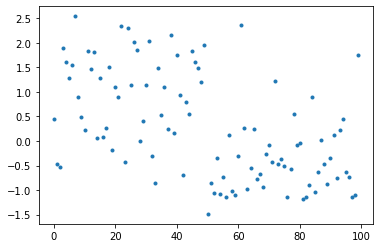

In [14]:
plt.plot(B0,'.');

In [15]:
B=hyper_score(N,K,edges,iterations=20)

Iteration: 0, Difference: 0.9270426661192044
Iteration: 1, Difference: 0.535134656930826
Iteration: 2, Difference: 0.3151250029512196
Iteration: 3, Difference: 0.2134264977441332
Iteration: 4, Difference: 0.14612157904035125
Iteration: 5, Difference: 0.10359142837298295
Iteration: 6, Difference: 0.07352265030365154
Iteration: 7, Difference: 0.052851418611659255
Iteration: 8, Difference: 0.037990618574828564
Iteration: 9, Difference: 0.027471797572659957
Iteration: 10, Difference: 0.0198732089011833
Iteration: 11, Difference: 0.014427124316320455
Iteration: 12, Difference: 0.010482489038745527
Iteration: 13, Difference: 0.007636375688626572
Iteration: 14, Difference: 0.005569769585865532
Iteration: 15, Difference: 0.004071904716810508
Iteration: 16, Difference: 0.002981281688477966
Iteration: 17, Difference: 0.0021877796085315693
Iteration: 18, Difference: 0.0016082065162064433
Iteration: 19, Difference: 0.00118496151913995


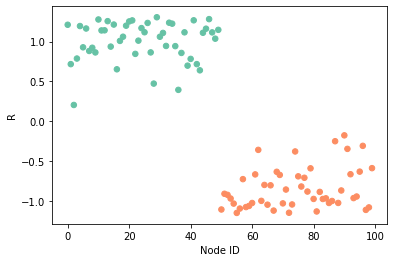

In [16]:
plt.scatter(range(len(B)), B, s=30,c=comm, cmap=ListedColormap(sns.color_palette("Set2", 2)));
plt.xlabel('Node ID');
plt.ylabel('R');

In [17]:
G=get_incidence(edges)

In [18]:
B2=score(G,K)

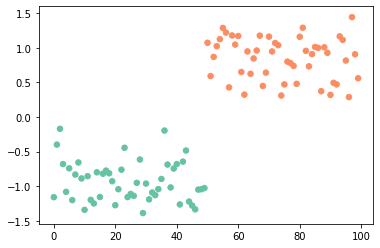

In [19]:
plt.scatter(range(len(B2)), B2, s=30,c=comm, cmap=ListedColormap(sns.color_palette("Set2", 2)));

## Real Data

### Statistician Network

* Edges: papers published in the statistics journals.
* Nodes: authors of the papers.

In [23]:
G=load_edges('../Data/Statistician/statistician.tsv')
node_names=pd.read_csv('../Data/Statistician/statistician_names.csv',sep='\t')
node_names.columns=['node_id','name']

In [24]:
G2, nodes, _=largest_component(G,2)
N=G2.shape[1]

In [25]:
node_names=node_names.merge(pd.DataFrame({"node_id":nodes}), on='node_id')

In [26]:
edges=get_hyperedges(G2)

In [27]:
print("Distribution of edge sizes:")
print(sorted(Counter([len(i) for i in edges]).items()))

Distribution of edge sizes:
[(2, 207), (3, 124), (4, 20), (6, 1)]


Add dummy nodes to make all edges of size $m$

In [28]:
m=4
dummies,regular_edges=homogenize(N,m,edges)

Set the number of communities $K$ and do HOSVD

In [29]:
K=3
U0 = hosvd(N+dummies,K,regular_edges)
B0 = U0[:,:-1]/U0[:,-1].reshape(len(U0),1)

Visualization of HOSVD Result

In [30]:
source = ColumnDataSource(
        data=dict(
            x=B0[:N,0],
            y=B0[:N,1],
            desc=node_names['name'],
            s=np.log(G2.sum(axis=0).A.ravel()+1)*5
        )
    )

hover = HoverTool(
        tooltips=[
            ("", "@desc"),
        ]
    )

p = figure(plot_width=750, plot_height=500)

p.circle('x', 'y', size='s', source=source, fill_alpha=0.5)
p.add_tools(hover)
show(p)

Full Tucker decomposition

In [31]:
B=hyper_score(N+dummies,K,regular_edges,iterations=20)

Iteration: 0, Difference: 2.0416923786738703
Iteration: 1, Difference: 2.147050862591479
Iteration: 2, Difference: 2.3358127735809386
Iteration: 3, Difference: 2.2976960198376863
Iteration: 4, Difference: 2.2331475123955915
Iteration: 5, Difference: 2.0393607284004216
Iteration: 6, Difference: 1.0518379749105622
Iteration: 7, Difference: 1.0125450412398902
Iteration: 8, Difference: 0.9526473575797769
Iteration: 9, Difference: 0.921116265138677
Iteration: 10, Difference: 0.8931980081341686
Iteration: 11, Difference: 0.9936032946714622
Iteration: 12, Difference: 0.962586748471463
Iteration: 13, Difference: 0.8394179541206633
Iteration: 14, Difference: 1.057230002572051
Iteration: 15, Difference: 0.8384398158899286
Iteration: 16, Difference: 0.7560899357881384
Iteration: 17, Difference: 0.7606341110882837
Iteration: 18, Difference: 0.80435736659905
Iteration: 19, Difference: 1.067920242103396


/home/bill10/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


Visualization of Tucker result

In [32]:
source = ColumnDataSource(
        data=dict(
            x=B[:N,0],
            y=B[:N,1],
            desc=node_names['name'],
            s=np.log(G2.sum(axis=0).A.ravel()+1)*5
        )
    )

hover = HoverTool(
        tooltips=[
            ("", "@desc"),
        ]
    )

p = figure(plot_width=750, plot_height=500)

p.circle('x', 'y', size='s', source=source, fill_alpha=0.5)
p.add_tools(hover)
show(p)

Project to simple graph and do SCORE

In [33]:
B2=score(G2,K,project='binary')

In [34]:
source = ColumnDataSource(
        data=dict(
            x=B2[:N,0],
            y=B2[:N,1],
            desc=node_names['name'],
            s=np.log(G2.sum(axis=0).A.ravel()+1)*5
        )
    )

hover = HoverTool(
        tooltips=[
            ("", "@desc"),
        ]
    )

p = figure(plot_width=750, plot_height=500)

p.circle('x', 'y', size='s', source=source, fill_alpha=0.5)
p.add_tools(hover)
show(p)